In [1]:
import os; print(os.getcwd())
import socket; print(socket.gethostname())

/mnt/net/scratch/ajasja/projects/truncator/R4_crystal_nMS_Y2H
dig3


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from glob import glob
#import sys; sys.path.insert(0, "/home/ajasja/projects/truncator/")
import truncator



In [3]:
out_dir_base = "out/R1"
pdb_files = glob(f"{out_dir_base}/03_score_SASA_SEQ/*/*.pdb");

def print_sele(row, name, color=None, remove_chains=False):
    try:
        sele = row[name+"_pymol_selection"]
        sele=sele.replace("rosetta_sele", name)
        if remove_chains:
            sele=sele.replace("chain A and", "").replace("chain B and", "")
        print(sele)
        if not color is None:
            print(f"color {color}, {name}")
    except:
        pass

def print_layers(row, selections="core bdry surf".split(), colors="red orange yellow".split()):
    for sele, col  in zip(selections, colors):
        print_sele(row, sele, col)

def print_selection(row, selection):
    full_name = row.full_name
    
    print("delete all")
    print(f"load {full_name}") 
    if truncator.is_str(selection):
        selection = [selection]
    for sele in selection:
        print_sele(row, sele, None)
    print_layers(row)
    

    print("orient")   
    


In [4]:
%%time
score_files = sorted(glob(f"{out_dir_base}/03_score_SASA_SEQ/*/*_IA.sc")); print(len(score_files))
sc = truncator.read_score_files_with_cache(score_files,f"{out_dir_base}/03_score_SASA_SEQ/IA_scores.csv.gzip", load_full_pdb_path=False)
sc = sc.drop_duplicates(keep='last', subset=['decoy']).set_index('decoy', drop=False)
sc['kind']='trunc'

26802
CPU times: user 3.24 s, sys: 329 ms, total: 3.57 s
Wall time: 5.5 s


In [5]:
[col for col in sc.columns if 'seq' in col]

['bndr_chA_sequence',
 'bndr_chB_sequence',
 'chA_sequence',
 'chB_sequence',
 'core_chA_sequence',
 'core_chB_sequence',
 'surf_chA_sequence',
 'surf_chB_sequence',
 'seq']

In [6]:
sc['seq'] = sc.chA_sequence +  sc.chB_sequence
sc['seq_core'] = sc.core_chA_sequence +  sc.core_chB_sequence

In [7]:
sc['nres'] = sc.seq.str.len()
sc['ala_count'] = sc.seq_core.str.count('A')
sc['met_count'] = sc.seq_core.str.count('M')
sc['phe_count'] = sc.seq_core.str.count('F')
sc['tyr_count'] = sc.seq_core.str.count('Y')
sc['trp_count'] = sc.seq_core.str.count('W')
sc['his_count'] = sc.seq_core.str.count('H')
sc['score_per_res'] = sc.total_score/sc.nres
sc['hbnet_res_count'] = sc.seq.str.count('(N|Q|T|W|Y|S|H)')

In [8]:
sc['core_polars_pymol_sel'] = sc.core_polars_pymol_selection.str.count(r'\d+')
sc['core_polars']  = sc.seq_core.str.count('(N|Q|T|W|Y|S|H|D|E|R|K)')

In [9]:
sc['frx_total_exposed_hydrophobics']=sc['total_exposed_hydrophobics']/sc['total_SASA']
sc['chA_frx_total_exposed_hydrophobics']=sc['chA_exposed_hydrophobics']/sc['chA_SASA']
sc['chB_frx_total_exposed_hydrophobics']=sc['chB_exposed_hydrophobics']/sc['chB_SASA']
sc['interface_hpatch']=-sc['total_hpatch_score']+sc['chA_hpatch_score']+sc['chB_hpatch_score']
sc['interface_exposed_hydrophobics']=-sc['total_exposed_hydrophobics']+sc['chA_exposed_hydrophobics']+sc['chB_exposed_hydrophobics']
sc['interface_hydrophobic_SASA']=-sc['total_hydrophobic_SASA']+sc['chA_hydrophobic_SASA']+sc['chB_hydrophobic_SASA']
sc['interface_SASA']=-sc['total_SASA']+sc['chA_SASA']+sc['chB_SASA']
sc['interface_polar_SASA']=-sc['total_polar_SASA']+sc['chA_polar_SASA']+sc['chB_polar_SASA']

sc['frx_interface_polar_SASA']=sc['interface_polar_SASA']/sc['interface_SASA']
sc['num_core_hbnet_residues_total']=sc['num_core_hbnet_residues_chA']+sc['num_core_hbnet_residues_chB']
sc['num_core_total']=sc['num_core_chA']+sc['num_core_chB']

In [10]:
list(sc.columns)
name_split=sc.decoy.str.split("__", expand=True)


In [11]:
sc['base']=name_split[0]
sc['numH']=name_split[1].str.replace('numH','').astype(float)
sc['from']=name_split[2].str.replace('from','').astype(float)
sc['to']=name_split[3].str.replace('to','').astype(float)
sc['gr']=name_split[4].str.replace('gr','')


In [12]:
CRYSTAL_STRUCTS = ['ZCON_13', 'ZCON_15', 'ZCON_37', 'ZCON_127', 'ZCON_131']
sc['crystal']=0
sc['base'].str.contains(CRYSTAL_STRUCTS[0])
for name in CRYSTAL_STRUCTS:
    sc['crystal'] = sc['crystal'] + (sc['base']==name)
    sc['crystal'] = sc['crystal'] + sc['base'].str.contains(name+'_')
sc['crystal']= sc['crystal'] > 0

In [13]:
#get the topology
gsplit = sc['gr'].str.split("-", expand=True);
gsplit[0]=gsplit[0].str.len().astype(str)
gsplit[1]=gsplit[1].str.len().astype(str)
sc['topology']=gsplit[0]+gsplit[1]


In [14]:
sns.set_style("whitegrid")
sns.set_context("talk")
def plot_hist(field_name, sc=sc):
    g = sns.FacetGrid(sc,  hue="kind", height=6, palette='bright')
    g = (g.map(sns.distplot, field_name, kde=False, norm_hist=False))
    g.add_legend()
    return g

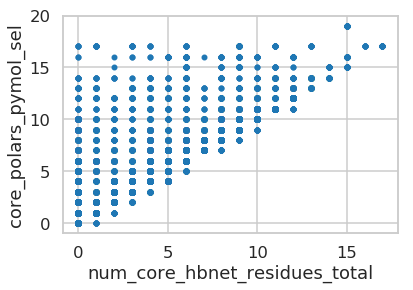

In [15]:
sc.plot.scatter('num_core_hbnet_residues_total', 'core_polars_pymol_sel')

In [16]:
#q = sc.query("base=='ZCON_37' and gr=='D-ABC' and crystal==1 and numH==4.5 and dSASA_polar>300").sort_values(by="interface_hbonds", ascending=False).groupby('base').head(5)
q = sc.query("numH==3.5 and sc_value>0.6 and core_buns_bb<3 and core_buns_sc==0 and frx_interface_polar_SASA>0.10")\
.sort_values(by="frx_interface_polar_SASA interface_hbonds  num_core_hbnet_residues_total".split(), ascending=[False, False, False])\
.groupby('base gr'.split()).head(3)

print(len(q))
q["base from to sc_value num_core_hbnet_residues_total core_polars_pymol_sel interface_hbonds  frx_interface_polar_SASA interface_polar_SASA interface_hydrophobic_SASA delta_unsatHbonds core_buns_bb core_buns_sc  interface_hpatch  interface_exposed_hydrophobics".split()
 ];



1710


In [17]:
h_lenghts=sc.numH.unique()

sc.frx_interface_polar_SASA.quantile(0.05)

0.12186294150142923

In [18]:
def return_closest_ids(df, col, val, top_n=2):
    sorted_series = abs(df[col]-val).sort_values()
    return list(sorted_series.iloc[:top_n].index)

return_closest_ids(sc, 'frx_interface_polar_SASA', 0.44, top_n=top_n)

NameError: name 'top_n' is not defined

In [47]:
def get_values_ids(df, col, vals, top_n=2):
    res=[]
    for val in vals:
        #print(df[col].quantile(quant))
        res.extend(return_closest_ids(df, col, val, top_n=top_n))
    return res


frx_polars = list(sc.frx_interface_polar_SASA.quantile([1, 0.75, 0.5]))
frx_polars = [0.5, 0.4, 0.3]
print(frx_polars)
get_values_ids(q, 'frx_interface_polar_SASA', frx_polars, top_n=2)

[0.5, 0.4, 0.3]


['ZCON_66__numH3.5__from-23.45__to07.42__grC-ABD',
 'ZCON_2_CC__numH3.5__from-13.73__to20.29__grB-ACD',
 'ZCON_2_CC__numH3.5__from-17.98__to16.05__grB-ACD',
 'ZCON_2_CC__numH3.5__from-13.73__to20.29__grA-BCD',
 'ZCON_101__numH3.5__from-19.85__to11.76__grAB-CD',
 'ZCON_13_AAAA__numH3.5__from-7.50__to24.91__grAB-CD']

In [57]:
ids = {}
for h_len in h_lenghts:
    qt = sc.query(f"numH=={h_len} and gr=='AB-CD' and sc_value>0.6 and core_buns_bb<3 and core_buns_sc==0 and frx_interface_polar_SASA>0.10")
    frx_polars = list(qt.frx_interface_polar_SASA.quantile([1, 0.75, 0.1]))
    print(frx_polars)
    ids[h_len] = get_values_ids(qt, 'frx_interface_polar_SASA', frx_polars, top_n=2)

[0.4136666360726621, 0.2682937433369382, 0.15701790515431205]
[0.39061577922143415, 0.26605609717065015, 0.15789611528621433]
[0.383504622356955, 0.2605361811156608, 0.16225326606335466]
[0.3796441961667241, 0.25750152941181786, 0.16743997816789852]
[0.35870823916810796, 0.25450527767786424, 0.16889948875295074]
[0.38381355296463476, 0.24772481154446413, 0.15803174440147594]


In [63]:
truncator.make_dirs("for_basile/03_more_polar")
truncator.write_json("for_basile/03_more_polar/ids.json", ids)

In [59]:
ids
#sc.to_json("for_basile/all_parameter_info.json.gz", compression='gzip')

{2.5: ['ZCON_66__numH2.5__from-6.17__to16.16__grAB-CD',
  'ZCON_154__numH2.5__from-15.70__to07.50__grAB-CD',
  'ZCON_157__numH2.5__from-19.21__to05.26__grAB-CD',
  'ZCON_142__numH2.5__from-24.03__to00.56__grAB-CD',
  'ZCON_43_AXA__numH2.5__from-3.73__to20.74__grAB-CD',
  'ZCON_29__numH2.5__from-3.66__to19.04__grAB-CD'],
 3.0: ['ZCON_67__numH3__from-18.41__to08.08__grAB-CD',
  'ZCON_150__numH3__from-8.64__to21.98__grAB-CD',
  'ZCON_88__numH3__from-11.49__to15.71__grAB-CD',
  'ZCON_161__numH3__from-15.47__to12.44__grAB-CD',
  'ZCON_120__numH3__from-21.59__to06.02__grAB-CD',
  'ZCON_21__numH3__from-4.09__to20.37__grAB-CD'],
 3.5: ['ZCON_67__numH3.5__from-5.02__to25.72__grAB-CD',
  'ZCON_67__numH3.5__from-6.94__to23.80__grAB-CD',
  'ZCON_121__numH3.5__from-19.99__to12.85__grAB-CD',
  'ZCON_127__numH3.5__from-14.59__to18.49__grAB-CD',
  'ZCON_96__numH3.5__from-24.28__to08.34__grAB-CD',
  'ZCON_124__numH3.5__from-16.05__to16.83__grAB-CD'],
 4.0: ['ZCON_67__numH4__from-18.41__to16.58__grAB-CD

In [66]:
cut_pdb_files = glob(f"{out_dir_base}/01_cut/*/*.pdb");

In [69]:
for lenH in ids.keys():
    truncator.make_dirs(f"for_basile/03_more_polar/numH{lenH}")
    for decoy in ids[lenH]:
        decoy=decoy[:-9]
        print(decoy)
        full_name = truncator.find_input(decoy, cut_pdb_files)
        print(full_name)
        !cp {full_name} for_basile/03_more_polar/numH{lenH}

ZCON_66__numH2.5__from-6.17__to16.16
out/R1/01_cut/2.5H/ZCON_66__numH2.5__from-6.17__to16.16.pdb
ZCON_154__numH2.5__from-15.70__to07.50
out/R1/01_cut/2.5H/ZCON_154__numH2.5__from-15.70__to07.50.pdb
ZCON_157__numH2.5__from-19.21__to05.26
out/R1/01_cut/2.5H/ZCON_157__numH2.5__from-19.21__to05.26.pdb
ZCON_142__numH2.5__from-24.03__to00.56
out/R1/01_cut/2.5H/ZCON_142__numH2.5__from-24.03__to00.56.pdb
ZCON_43_AXA__numH2.5__from-3.73__to20.74
out/R1/01_cut/2.5H/ZCON_43_AXA__numH2.5__from-3.73__to20.74.pdb
ZCON_29__numH2.5__from-3.66__to19.04
out/R1/01_cut/2.5H/ZCON_29__numH2.5__from-3.66__to19.04.pdb
ZCON_67__numH3__from-18.41__to08.08
out/R1/01_cut/3.0H/ZCON_67__numH3__from-18.41__to08.08.pdb
ZCON_150__numH3__from-8.64__to21.98
out/R1/01_cut/3.0H/ZCON_150__numH3__from-8.64__to21.98.pdb
ZCON_88__numH3__from-11.49__to15.71
out/R1/01_cut/3.0H/ZCON_88__numH3__from-11.49__to15.71.pdb
ZCON_161__numH3__from-15.47__to12.44
out/R1/01_cut/3.0H/ZCON_161__numH3__from-15.47__to12.44.pdb
ZCON_120__numH3_

In [46]:
def print_load_script(row, iloc=None, prefix="S:\projects/truncator/R4_crystal_nMS_Y2H" ):
    if not iloc is None:
        row = row.ix[iloc]
    full_name = truncator.find_input(row.decoy, pdb_files)
    #print('delete all')
    print(f'load  {prefix}/{full_name} ')
    print(row.core_polars_pymol_selection)
    #print_layers(row, selections="core bndr surf".split())
    print('hbnet')

In [36]:
!pwd

/mnt/net/scratch/ajasja/projects/truncator/R4_crystal_nMS_Y2H


In [47]:
print_load_script(q, 1)

/software/conda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'Series' object has no attribute 'decoy'

In [18]:
for i in range(10):
    print_load_script(q, i)


load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_155__numH3__from-13.96__to16.63__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_152__numH3__from-12.50__to17.12__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_144__numH3__from-19.52__to09.67__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_151__numH3__from-16.61__to13.87__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_156__numH3__from-14.48__to15.38__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_15_re_loop__numH3__from04.80__to31.64__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_20__numH3__from04.66__to32.30__grAB-CD.pdb 
hbnet
load  S:\projects/truncator/R4_crystal_nMS_Y2H/out/R1/02_regruped/3.0H/ZCON_17__numH3__from05.02__to

/software/conda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
q = sc.query("base=='ZCON_37' and gr=='D-ABC' and numH==4.5").sort_values(by="interface_hbonds", ascending=False).head(50)

#plot_hist('interface_hbonds', q)

,interface_hbonds,dSASA_polar,delta_unsatHbonds,core_buns_bb,interface_hpatch
decoy,,,,,
ZCON_37__numH4.5__from-21.21__to22.24__grD-ABC,8,409.616394,2,0,94.239998
ZCON_37__numH4.5__from-23.34__to20.12__grD-ABC,7,391.057983,2,1,98.559998


load out/R3/02_regruped/4.5H/ZCON_37__numH4.5__from-21.21__to22.24__grAB-CD.pdb 


/software/conda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


In [56]:

print_load_script(q.iloc[0])

load out/R3/02_regruped/3.5H/ZCON_37__numH3.5__from-10.60__to23.42__grA-BCD.pdb 


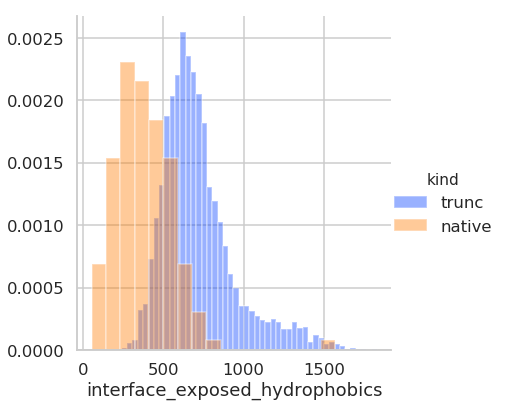

In [106]:
plot_hist('interface_exposed_hydrophobics')
#plt.xlim([-200, 200])

In [8]:
#print("\n".join(list(df.columns)));
cols = truncator.read_file_lines('col_order.list', skip_comments=True)
df = df[cols]


In [9]:
len(df)

6129

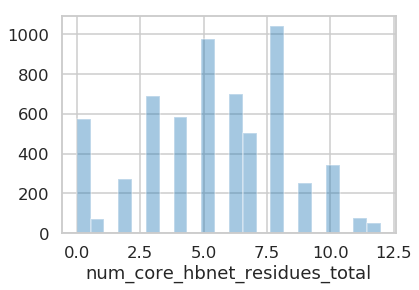

In [16]:

sns.distplot(df['num_core_hbnet_residues_total'].dropna(), kde=False)


In [7]:
logs = sorted(glob("out/01_fuse_to_3chain_14o_7r//*/*/*.sc"))
logs;

In [8]:
%%time
scores = u.load_score_files(logs, load_seq=True)

CPU times: user 1.78 s, sys: 56.4 ms, total: 1.83 s
Wall time: 2.09 s


In [36]:
scores.set_index('description', inplace=True, drop=False)

In [9]:
scores["n_aa"] = scores["seq"].str.len()

KeyError: 'seq'

In [14]:
scores["fa_rep_per_aa"] = scores["fa_rep"]/scores["n_aa"]

In [39]:
scores.to_csv("out/01_fuse_to_3chain_14o_7r.scores")

In [75]:
pd.set_option('display.max_colwidth', -1)
q =scores.sort_values(by='fa_rep').query('fa_rep<400 and sc2>0.5')
print(len(q))
chosen = q
q['total_score fa_rep fa_rep_per_aa clash_check_soft clash_check_hard longest_hpc uhb sc1 sc2 sc1_int_area sc2_int_area full_name'.split()][:10

43


In [76]:
chosen.columns

Index(['total_score', 'ala_count', 'clash_check_hard', 'clash_check_soft',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rep_fitler',
       'fa_sol', 'gen_bonded', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'hxl_tors', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'longest_hpc', 'omega',
       'p_aa_pp', 'pro_close', 'rama_prepro', 'ref', 'sc1', 'sc1_int_area',
       'sc2', 'sc2_int_area', 'ss_count', 'uhb', 'full_name', 'seq', 'n_aa',
       'fa_rep_per_aa', 'description'],
      dtype='object')

In [77]:
import os
def row_to_worms_dict(row):
    d = {}
    d['file'] = os.path.abspath(row.full_name)
    d['name'] = row.description
    d['class'] = ["Het"]
    d['type'] = ["AL_het_C2_N_C"]
    d['base'] = "ZCON37" 
    d['components'] = ["ZCON37", "DHR1", "DHR2"]
    d['validated'] = False
    d['protocol'] =  "Made by Ajasja with H-fuse"
    d['connections'] = [
        {"chain": 1, "direction": "N", "residues":["1:50"]},
        {"chain": 2, "direction": "C", "residues":["-50:"]}
    ]
    return d


In [84]:
def dataframe_to_worms_database(df, out_file=None):
    res = []
    for row in df.itertuples():
        res.append(row_to_worms_dict(row))
    import json
    if out_file is None:
        return json.dumps(res, indent=4)
    with open(out_file, "w") as write_file:
        json.dump(res, write_file, indent=2)
        
dataframe_to_worms_database(chosen, "ALSD01_2018-11-07.database")      

In [45]:

df = pd.DataFrame({'a': np.random.randn(1000), 'b': np.random.randn(1000),'N': np.random.randint(100, 1000, (1000)), 'x': 'x'})

%timeit [row.a * 2 for idx, row in df.iterrows()]
# => 10 loops, best of 3: 50.3 ms per loop

%timeit [row.a * 2 for row in df.itertuples()]
# => 1000 loops, best of 3: 541 µs per loop

188 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.98 ms ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
188/2.98

63.08724832214765